In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import matplotlib.pyplot as plt


In [19]:
features_df = pd.read_csv('combined_user_features.csv')
print("Số dòng dữ liệu:", features_df.shape[0])

Số dòng dữ liệu: 25669


In [20]:
features_df.head(5)

,profile_id,in_degree,out_degree,betweenness,closeness,eigenvector,gnn_emb_0,gnn_emb_1,gnn_emb_2,gnn_emb_3,...,gnn_emb_6,gnn_emb_7,gnn_emb_8,gnn_emb_9,gnn_emb_10,gnn_emb_11,gnn_emb_12,gnn_emb_13,gnn_emb_14,gnn_emb_15
0,14,0.018758,0.019115,0.113038,0.739306,0.0,0.588825,0.032355,0.828369,-0.817316,...,-0.125660,0.303268,0.179344,0.904536,-0.597845,-0.557870,-0.067527,-0.594947,-0.681053,-0.247779
1,512,0.000000,0.000354,0.000000,0.000000,0.0,0.632943,-0.306380,-0.133208,-1.507565,...,0.226926,1.363894,-1.329570,1.045919,0.327337,2.972932,0.388515,-0.170770,-0.810858,0.301865
2,533,0.000308,0.000354,0.000000,0.708484,0.0,-0.165315,-0.741650,0.762098,-1.252277,...,-1.088729,0.131084,-0.581377,0.128293,0.350551,-0.470183,-0.408946,2.112508,0.732507,0.743471
3,534,1.000000,1.000000,1.000000,0.983790,0.0,-0.675118,0.867779,0.137951,0.349359,...,0.243103,-0.655177,0.963023,-0.659326,1.014212,0.057761,0.034491,-0.632860,0.208144,-0.232271
4,564,0.033825,0.001062,0.002480,0.751234,0.0,-0.236927,-0.497405,0.383309,0.069869,...,-0.293359,0.401449,-0.065351,-0.117498,0.075035,0.060004,-0.200489,-0.519992,-0.111456,0.186896


In [21]:
features_df['follower_following_ratio'] = features_df.apply(
    lambda row: row['in_degree'] / row['out_degree'] if row['out_degree'] > 0 else row['in_degree'], axis=1)

In [22]:
features_df.head(5)

,profile_id,in_degree,out_degree,betweenness,closeness,eigenvector,gnn_emb_0,gnn_emb_1,gnn_emb_2,gnn_emb_3,...,gnn_emb_7,gnn_emb_8,gnn_emb_9,gnn_emb_10,gnn_emb_11,gnn_emb_12,gnn_emb_13,gnn_emb_14,gnn_emb_15,follower_following_ratio
0,14,0.018758,0.019115,0.113038,0.739306,0.0,0.588825,0.032355,0.828369,-0.817316,...,0.303268,0.179344,0.904536,-0.597845,-0.557870,-0.067527,-0.594947,-0.681053,-0.247779,0.981305
1,512,0.000000,0.000354,0.000000,0.000000,0.0,0.632943,-0.306380,-0.133208,-1.507565,...,1.363894,-1.329570,1.045919,0.327337,2.972932,0.388515,-0.170770,-0.810858,0.301865,0.000000
2,533,0.000308,0.000354,0.000000,0.708484,0.0,-0.165315,-0.741650,0.762098,-1.252277,...,0.131084,-0.581377,0.128293,0.350551,-0.470183,-0.408946,2.112508,0.732507,0.743471,0.868696
3,534,1.000000,1.000000,1.000000,0.983790,0.0,-0.675118,0.867779,0.137951,0.349359,...,-0.655177,0.963023,-0.659326,1.014212,0.057761,0.034491,-0.632860,0.208144,-0.232271,1.000000
4,564,0.033825,0.001062,0.002480,0.751234,0.0,-0.236927,-0.497405,0.383309,0.069869,...,0.401449,-0.065351,-0.117498,0.075035,0.060004,-0.200489,-0.519992,-0.111456,0.186896,31.852194


In [23]:
# Chọn các chỉ số mạng và một phần vector nhúng (có thể dùng toàn bộ hoặc trích chọn các chiều quan trọng)
centrality_columns = ['in_degree', 'out_degree','follower_following_ratio', 'betweenness', 'closeness', 'eigenvector']
embedding_columns = [f'gnn_emb_{i}' for i in range(16)]  # giả sử có 16 chiều nhúng: gnn_emb_0 ... gnn_emb_15
selected_columns = centrality_columns + embedding_columns

X = features_df[selected_columns].values

In [24]:
# 5. Xác định số lượng cụm (k) bằng Silhouette Score (tùy chọn)
# ---------------------------
k_values = range(2,10)
sil_scores = []
db_scores = []
ch_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=100)
    labels = kmeans.fit_predict(X)
    
    # Tính Silhouette Score
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    
    # Tính Davies-Bouldin Index
    db = davies_bouldin_score(X, labels)
    db_scores.append(db)
    
    # Tính Calinski-Harabasz Score
    ch = calinski_harabasz_score(X, labels)
    ch_scores.append(ch)
    print(f"[k={k}] Silhouette Score = {sil:.4f}, Davies-Bouldin = {db:.4f}, Calinski-Harabasz Score = {ch:.4f}" )


[k=2] Silhouette Score = 0.9828, Davies-Bouldin = 0.2059, Calinski-Harabasz Score = 24150.0133
[k=3] Silhouette Score = 0.0425, Davies-Bouldin = 3.2023, Calinski-Harabasz Score = 13068.4012
[k=4] Silhouette Score = 0.0370, Davies-Bouldin = 3.1918, Calinski-Harabasz Score = 9188.6262
[k=5] Silhouette Score = 0.0385, Davies-Bouldin = 3.0437, Calinski-Harabasz Score = 7231.3121
[k=6] Silhouette Score = 0.0371, Davies-Bouldin = 2.9727, Calinski-Harabasz Score = 5989.1676
[k=7] Silhouette Score = 0.0374, Davies-Bouldin = 2.8981, Calinski-Harabasz Score = 5150.9426
[k=8] Silhouette Score = 0.0380, Davies-Bouldin = 2.6340, Calinski-Harabasz Score = 4790.8729
[k=9] Silhouette Score = 0.0380, Davies-Bouldin = 2.6064, Calinski-Harabasz Score = 4301.4505


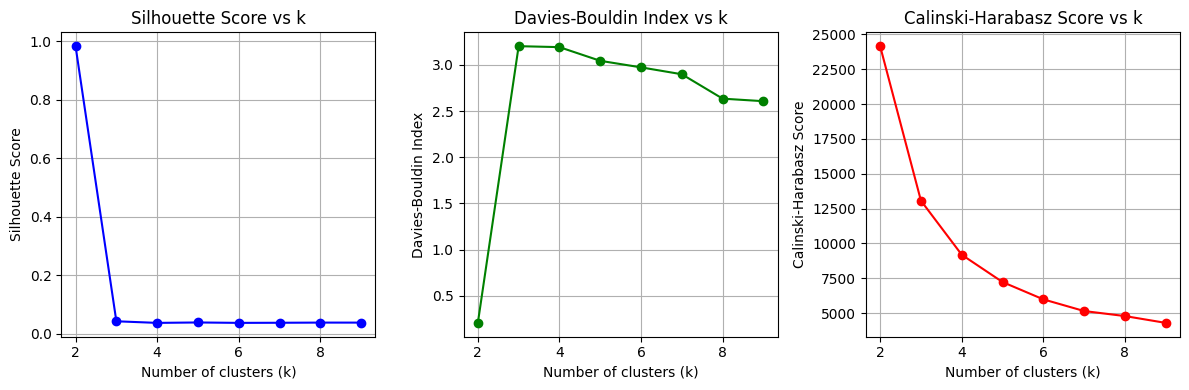

In [25]:
plt.figure(figsize=(12,4))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_values, sil_scores, marker='o', color='blue')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.grid(True)

# Davies-Bouldin Index (càng thấp càng tốt)
plt.subplot(1, 3, 2)
plt.plot(k_values, db_scores, marker='o', color='green')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs k")
plt.grid(True)

# Calinski-Harabasz Score (càng cao càng tốt)
plt.subplot(1, 3, 3)
plt.plot(k_values, ch_scores, marker='o', color='red')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score vs k")
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
features_df['cluster'] = kmeans.fit_predict(X)

In [32]:
# 6. Kiểm tra trung tâm các cụm để xem đặc trưng nào nổi bật
# ---------------------------
cluster_centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(cluster_centers, columns=selected_columns)
print("Trung tâm các cụm:")
print(centers_df)

Trung tâm các cụm:
   in_degree  out_degree  follower_following_ratio  betweenness  closeness  \
0   0.000594    0.000737                  0.347529     0.000269   0.341760   
1   0.300277    0.001150                331.885378     0.118780   0.812356   

   eigenvector  gnn_emb_0  gnn_emb_1  gnn_emb_2  gnn_emb_3  ...  gnn_emb_6  \
0          0.0   0.000069  -0.000081  -0.000012  -0.000042  ...  -0.000014   
1          0.0  -0.440195   0.517923   0.074652   0.269193  ...   0.092294   

   gnn_emb_7  gnn_emb_8  gnn_emb_9  gnn_emb_10  gnn_emb_11  gnn_emb_12  \
0   0.000042  -0.000036   0.000063   -0.000058    0.000009   -0.000043   
1  -0.272340   0.233463  -0.407073    0.374554   -0.059416    0.275569   

   gnn_emb_13  gnn_emb_14    gnn_emb_15  
0    0.000012   -0.000065 -9.385745e-07  
1   -0.078760    0.415463  5.945676e-03  

[2 rows x 22 columns]


<Figure size 1200x600 with 0 Axes>

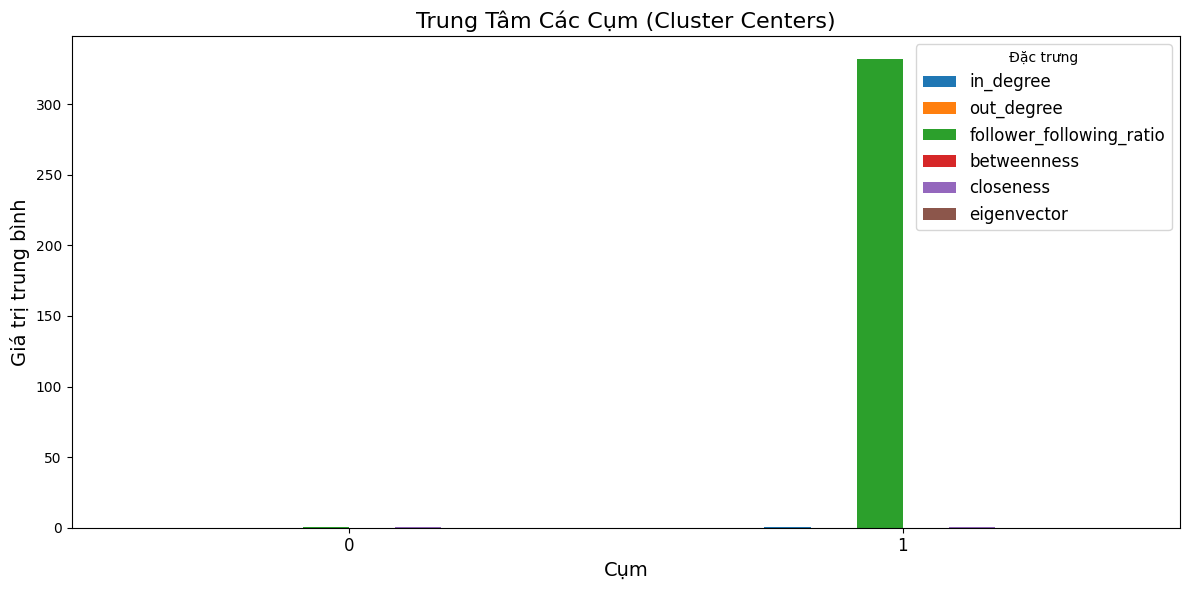

In [33]:
center_label = pd.DataFrame(centers_df.iloc[:, :6])
plt.figure(figsize=(12, 6))
center_label.plot(kind="bar", figsize=(12, 6))

# Đặt tiêu đề và nhãn
plt.title("Trung Tâm Các Cụm (Cluster Centers)", fontsize=16)
plt.xlabel("Cụm", fontsize=14)
plt.ylabel("Giá trị trung bình", fontsize=14)
plt.xticks(rotation=0, fontsize=12)  # Hiển thị tên cụm
plt.legend(title="Đặc trưng", fontsize=12)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [34]:
role_map = {
    0: 'Influencers',       # Ví dụ: cụm có tỷ lệ follower/following cao, betweenness cao
    1: 'Active Followers',  # Ví dụ: cụm có out_degree lớn nhưng in_degree thấp
    2: 'Community Leaders', # Ví dụ: cụm có closeness hoặc degree cao
    3: 'Lurkers',           # Ví dụ: cụm có cả in_degree và out_degree nhỏ
    4: 'Bridge Builders'    # Ví dụ: cụm có betweenness cao, đóng vai trò cầu nối
}

features_df['role'] = features_df['cluster'].map(role_map)

In [35]:
features_df.to_csv('user_roles_clustered.csv', index=False)
print("Đã lưu kết quả phân cụm và gán nhãn vai trò vào file 'user_roles_clustered.csv'")
print("Phân bố các vai trò:")
print(features_df['role'].value_counts())

Đã lưu kết quả phân cụm và gán nhãn vai trò vào file 'user_roles_clustered.csv'
Phân bố các vai trò:
role
Influencers         25665
Active Followers        4
Name: count, dtype: int64
